# Randomization metric
We run MPRT (randomization) from Quantus on our explainer and compare to a random baseline.

In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings related to versions of tf
import numpy as np
import dianna
import quantus

2024-01-09 11:54:52.969032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


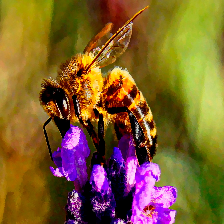

In [2]:
def load_img(path, target_size):
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.resnet50 import preprocess_input
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

bee_img, bee_arr = load_img('data/bee.jpg', (224,224,3))
bee_img

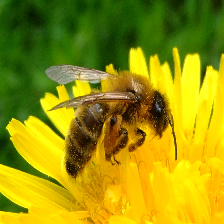

In [3]:
from pathlib import Path

reference_img, reference_arr = load_img(
    Path('data/bee2.jpg'),
    (224, 224, 3))
reference_img

In [4]:
import matplotlib.pyplot as plt

def plot_hist(result):
    data = []
    for key, value in result.items():
        for _ in range(int(value)):
            data.append(key)

    # plot the histogram
    plt.hist(data, bins=range(0, 101, 10), align='mid')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Results')
    plt.show()

In [16]:
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50()

def random_xai(model, input_data, method, labels, **kwargs):
    output = np.random.randn(*input_data.shape[:-1])[None,...]
    return output

random_result = quantus.MPRT()(
    model=model,
    x_batch=bee_arr,
    y_batch=[309],
    a_batch=None,
    explain_func= random_xai,
    explain_func_kwargs={'model_or_function': model,
                        "input_data": bee_arr[0],
                        "method": "RISE",
                        "labels": range(1),
                       }
)
print(random_result)

{'original': [-0.00526839121828136], 'predictions': [-0.002666054224704653], 'conv5_block3_3_bn': [-0.0012186178987912335], 'conv5_block3_3_conv': [-0.002554870908481793], 'conv5_block3_2_bn': [-0.0033143400529737064], 'conv5_block3_2_conv': [-0.0030357146407043794], 'conv5_block3_1_bn': [-0.0033143400529737064], 'conv5_block3_1_conv': [-0.0030357146407043794], 'conv5_block2_3_bn': [-0.0012186178987912335], 'conv5_block2_3_conv': [-0.002554870908481793], 'conv5_block2_2_bn': [-0.0033143400529737064], 'conv5_block2_2_conv': [-0.0030357146407043794], 'conv5_block2_1_bn': [-0.0033143400529737064], 'conv5_block2_1_conv': [-0.0030357146407043794], 'conv5_block1_3_bn': [-0.0012186178987912335], 'conv5_block1_0_bn': [-0.0012186178987912335], 'conv5_block1_3_conv': [-0.002554870908481793], 'conv5_block1_0_conv': [-0.002554870908481793], 'conv5_block1_2_bn': [-0.0033143400529737064], 'conv5_block1_2_conv': [-0.0030357146407043794], 'conv5_block1_1_bn': [-0.0033143400529737064], 'conv5_block1_1_

In [65]:
import scipy.stats

In [100]:
scipy.stats.spearmanr(np.random.randn(224*224),  np.random.randn(224*224))

SignificanceResult(statistic=-0.0002667834210295694, pvalue=0.952348378014034)

In [48]:
import distance_explainer.distance
# import importlib
# importlib.reload(distance_explainer.distance)

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50()
embedded_reference = model(reference_arr)

img_shape = bee_arr.shape[1:3]
n_masks = 500
masks = distance_explainer.distance.generate_masks_for_images(img_shape, n_masks, 0.5, 8)

channel_first = True  # transpose to always have channels first (pytorch style)

def explain(model, inputs, targets, **kwargs) -> np.ndarray:
    """

    :param model:
    :param inputs:
    :param targets: Ignored, added because of required signature (source: https://captum.ai/api/gradient_shap.html#captum.attr.GradientShap.attribute)
    :param kwargs:
    :return:
    """

    if channel_first:
        inputst = inputs.transpose([0,2,3,1])
    else:
        inputst = inputs

    # see C:\Users\ChristiaanMeijer\anaconda3\envs\distance_explainer311\Lib\site-packages\quantus\functions\explanation_func.py
    batch_size = inputst.shape[0]
    saliencies = np.empty(inputst.shape)
    for i in range(batch_size):
        saliencies[i], _ = distance_explainer.distance.DistanceExplainer(axis_labels=['x','y','channels'], n_masks=n_masks).explain_image_distance(model, inputst[i], embedded_reference, masks=masks)

    # See quantus\metrics\base.py:l425 Channels first!
    if channel_first:
        return saliencies.transpose([0,3,1,2])
    else:
        return saliencies

In [15]:
from pandas import DataFrame

if True:
    x_batch = bee_arr.transpose([0,3,1,2])
else:
    x_batch = bee_arr

result = []
for i in range(1):
    result.append(quantus.MPRT()(
        model=model,
        x_batch=x_batch,
        y_batch=[0],
        a_batch=None,
        channel_first=channel_first,
        explain_func=explain,
    ))
r_df = DataFrame(result)
print(r_df)
# print(r_df.describe())

Explaining: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.10s/it]


  original           predictions     conv5_block3_3_bn   conv5_block3_3_conv  \
0    [1.0]  [0.1465212638110494]  [0.1465212638110494]  [0.1465212638110494]   

      conv5_block3_2_bn    conv5_block3_2_conv      conv5_block3_1_bn  \
0  [0.1465212638110494]  [0.13680499048430084]  [0.13680499048430084]   

     conv5_block3_1_conv      conv5_block2_3_bn    conv5_block2_3_conv  ...  \
0  [0.13680499048430084]  [0.13680499048430084]  [0.13680499048430084]  ...   

       conv2_block1_3_bn      conv2_block1_0_bn    conv2_block1_3_conv  \
0  [0.13591520238057003]  [0.13591520238057003]  [0.13591520238057003]   

     conv2_block1_0_conv      conv2_block1_2_bn    conv2_block1_2_conv  \
0  [0.13591520238057003]  [0.13591520238057003]  [0.13002168507004555]   

       conv2_block1_1_bn    conv2_block1_1_conv               conv1_bn  \
0  [0.13002168507004555]  [0.13002168507004555]  [0.13002168507004555]   

             conv1_conv  
0  [0.1317891453445463]  

[1 rows x 108 columns]
       ori

The numbers are Spearman correlations of all the values in two saliency maps; the original compared to that generated using a model where layers are randomized. The first number ("original") has no layers randomized, so Spearman correlation is 1 (exactly equal). From then on, first the top layer is randomized, then the next, etc.

Randomizing the top layer (predictions) apparantly is the only impactful change; after that, no more significant change in the correlation can be seen. Still, there seems to be some correlation left, which is interesting. But is this (~0.29) a meaningful correlation? Or is this just random noise?